In [3]:
using Plots
using ParticleFilters
using Distributions
using StaticArrays
using LinearAlgebra
using Random
using StatsBase
#using Reel
using SparseArrays
using GridInterpolations
using DataStructures
using DataFrames
using CSV
using Distributed

In [37]:

include("atan2.jl")
include("obs_rel.jl")
include("polargrid_rel_qual2.jl")
rng = MersenneTwister(2);
#

In [5]:
# random walk

POS_0 = [6.0, 60.0]
CRS_0 = 90 # target's course
SPD_0 = 1 # 1 or 2
TGT_SPD = 1

#input is course in degrees and rng
#returns next course in degrees
function next_crs(crs,rng)
    if rand(rng) < .9
        return crs
    end
    crs = (crs + rand(rng,[-1,1])*30) % 360
    if crs < 0 crs += 360 end
    return crs
end

# state as tuple (x, y, crs, spd) of target (spd of o/s)
function f(state, control, rng)
    r, θ, crs, spd = state
    θ += control[1]
    spd = control[2]
    if θ < 0 θ += 360 end
    θ = θ % 360
    crs -= control[1]
    if crs < 0 crs += 360 end
    crs = crs % 360
    x = r*cos(π/180*θ)
    y = r*sin(π/180*θ)
    pos = [x + TGT_SPD*cos(π/180*crs) - spd, y + 
        TGT_SPD*sin(π/180*crs)]
    crs = next_crs(crs,rng)
    r = sqrt(pos[1]^2 + pos[2]^2)
    θ = atan2(pos[1],pos[2])*180/π
    if θ < 0 θ += 360 end
    return (r, θ, crs, spd)::NTuple{4, Real}
end
#

f (generic function with 1 method)

In [6]:
function r(s)
    range = s[1]
    if range > 150 return -.2 end  # reward to not lose track of contact
    if range <= 10 return -100 end  # collision avoidance
    return .1  # being in "sweet spot" maximizes reward
end
#

r (generic function with 1 method)

In [7]:
#angles = [0, 30, 60, 90, 120, 150, 210, 240, 270, 300, 330]

statespace = thestates
actionspace = ((30,1), (0,1), (-30,1), (30, 2), (0,2), (-30,2))

action_index(a) = trunc(Int, 2*(a[1]/30+1) + a[2])
actions_ = ((-30,1), (-30, 2), (0, 1), (0, 2), (30, 1), (30, 2))



((-30, 1), (-30, 2), (0, 1), (0, 2), (30, 1), (30, 2))

In [8]:
# returns vector rather than Tuple, for particle filter
function f2(x, u, rng)
    temp = [i for i in f(x, u, rng)]
    return temp
end

f2 (generic function with 1 method)

In [9]:
totals = [0.0]
θ = zeros(length(grid),6);
e = sparse(zeros(length(grid),6))
#θ = [r(Tuple(ind2x(grid, j))) for j in 1:length(grid), i in 1:6];

In [47]:

N = 250
model = ParticleFilterModel{Vector{Float64}}(f2, g)
pfilter = SIRParticleFilter(model, N);
α = 0.3
γ = 0.9
ϵ = 0.05
x = [20, 60, 90, 1, 1];
λ = 0.9
b = ParticleCollection([[20, 60, 90, 1] for i in 1:N]);
counter = 0


0

In [ ]:
## Q-learning loop
#plots = []
#betas = Deque{Array}()
#β = zeros(length(grid),6);
# fixed 500-size epoch

epochsize = 500
epochs = 5000


total = 0
rando = 0
rando += uu[2]
k = 15
last = 0
x = [rand(rng, 25:150), rand(rng,0:359), rand(rng,0:11)*30, 1, 1];     
b = ParticleCollection([x[1:4] for i in 1:N]);     
ξ = sparse(weighted_grid_2(b)/N)
uu = next_action([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], ϵ, rng)
u = uu[1]

for i in 1:(epochsize*epochs)
    counter += 1
    
    e[:,u] += ξ
    last = transpose(θ[:,u])*ξ
    
    # choose next action
    #uu = softmax_action([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], k, rng)
    uu = next_action([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], ϵ, rng)
    u = uu[1]
    rando += uu[2]
    a_star = uu[3]
    
    #observe new state and reward
    xp = f2(x, actions_[u], rng)
    y = h(xp, rng)
    b = update(pfilter, b, actions_[u], y)
    rew = r(Tuple(xp))
       
    ξ = sparse(weighted_grid_2(b)/N)
     
    total += rew
        
    #cur = (rew + γ * max2([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], rng))
    
    #argmax state-action pair, not realized state-action pair?
    cur = transpose(θ[:,a_star])*ξ
    
    δ = rew + γ * cur - last
    
    θ += α * δ * e
    #if uu[2] == 0
    e *= γ * λ
    #else
    #    e = sparse(zeros(length(grid),6))
    #end
    
        
    if (counter % epochsize == 0) || (xp[1] <= 10)
        push!(totals, total*500/epochsize)
        println("--------- CURRENT: ", round(total*500/epochsize, sigdigits=4), " AVG: ", round(mean(totals), sigdigits=4), " Epoch: ", 
            trunc(Int, counter/epochsize), " -----------")
        total = 0
        rando = 0
        xp = [rand(rng, 25:150), rand(rng,0:359), rand(rng,0:11)*30, rand(rng, [1,2]), 1];
        uu = next_action([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], ϵ, rng)
        u = uu[1]
        b = ParticleCollection([xp[1:4] for i in 1:N]);
        ξ = sparse(weighted_grid_2(b)/N)
        #ϵ = max(75-counter/(1.3e6),0)
        running_avg = mean(totals)
        if running_avg > 0 
            k = max(running_avg+10, 1)
        else
            k = 1
        end
        
    end
    if counter % (epochsize*5) == 0
        thetaframe = DataFrame(θ)
        CSV.write("current47_2.csv", thetaframe)
    end
    
    x = xp
    
    
    #plotting
    #r_ = [row[1] for row in particles(b)]
    #theta = [row[2] for row in particles(b)]*π/180
    #x_theta = x[2]*π/180
    #x_r = x[1 ]
    
    #print(".")
    #plt = plot(proj=:polar, lims=(0,200), size=(1000,1000))
    #scatter!(theta, r_, markersize=1, label="particles")
    #scatter!([x_theta], [x_r], markersize=3, label="target")
          
    #push!(plots, plt)
    
end


--------- CURRENT: 43.4 AVG: 35.23 Epoch: 1 -----------
--------- CURRENT: 50.0 AVG: 35.23 Epoch: 2 -----------
--------- CURRENT: 47.6 AVG: 35.23 Epoch: 3 -----------
--------- CURRENT: 50.0 AVG: 35.23 Epoch: 4 -----------
--------- CURRENT: -68.5 AVG: 35.22 Epoch: 4 -----------
--------- CURRENT: 17.5 AVG: 35.21 Epoch: 5 -----------
--------- CURRENT: 47.6 AVG: 35.22 Epoch: 6 -----------
--------- CURRENT: 50.0 AVG: 35.22 Epoch: 7 -----------
--------- CURRENT: 50.0 AVG: 35.22 Epoch: 8 -----------
--------- CURRENT: 44.3 AVG: 35.22 Epoch: 9 -----------
--------- CURRENT: 47.0 AVG: 35.22 Epoch: 10 -----------
--------- CURRENT: 49.7 AVG: 35.23 Epoch: 11 -----------
--------- CURRENT: 50.0 AVG: 35.23 Epoch: 12 -----------
--------- CURRENT: 50.0 AVG: 35.23 Epoch: 13 -----------
--------- CURRENT: 50.0 AVG: 35.23 Epoch: 14 -----------
--------- CURRENT: 50.0 AVG: 35.24 Epoch: 15 -----------
--------- CURRENT: 50.0 AVG: 35.24 Epoch: 16 -----------
--------- CURRENT: 50.0 AVG: 35.24 Epoch

--------- CURRENT: 49.7 AVG: 34.94 Epoch: 123 -----------
--------- CURRENT: 43.4 AVG: 34.94 Epoch: 124 -----------
--------- CURRENT: -40.9 AVG: 34.92 Epoch: 125 -----------
--------- CURRENT: -74.6 AVG: 34.91 Epoch: 125 -----------
--------- CURRENT: 24.5 AVG: 34.9 Epoch: 126 -----------
--------- CURRENT: 43.7 AVG: 34.91 Epoch: 127 -----------
--------- CURRENT: 50.0 AVG: 34.91 Epoch: 128 -----------
--------- CURRENT: 50.0 AVG: 34.91 Epoch: 129 -----------
--------- CURRENT: 50.0 AVG: 34.91 Epoch: 130 -----------
--------- CURRENT: 50.0 AVG: 34.92 Epoch: 131 -----------
--------- CURRENT: 41.0 AVG: 34.92 Epoch: 132 -----------
--------- CURRENT: 50.0 AVG: 34.92 Epoch: 133 -----------
--------- CURRENT: -61.9 AVG: 34.9 Epoch: 133 -----------
--------- CURRENT: 11.8 AVG: 34.9 Epoch: 134 -----------
--------- CURRENT: 49.1 AVG: 34.9 Epoch: 135 -----------
--------- CURRENT: 50.0 AVG: 34.9 Epoch: 136 -----------
--------- CURRENT: -98.6 AVG: 34.88 Epoch: 136 -----------
--------- CURRE

--------- CURRENT: 32.2 AVG: 34.22 Epoch: 223 -----------
--------- CURRENT: -94.1 AVG: 34.2 Epoch: 223 -----------
--------- CURRENT: -74.3 AVG: 34.18 Epoch: 223 -----------
--------- CURRENT: 18.2 AVG: 34.18 Epoch: 224 -----------
--------- CURRENT: 50.0 AVG: 34.18 Epoch: 225 -----------
--------- CURRENT: 46.7 AVG: 34.19 Epoch: 226 -----------
--------- CURRENT: 50.0 AVG: 34.19 Epoch: 227 -----------
--------- CURRENT: -58.1 AVG: 34.17 Epoch: 227 -----------
--------- CURRENT: 8.0 AVG: 34.17 Epoch: 228 -----------
--------- CURRENT: 49.1 AVG: 34.17 Epoch: 229 -----------
--------- CURRENT: 39.5 AVG: 34.17 Epoch: 230 -----------
--------- CURRENT: 50.0 AVG: 34.17 Epoch: 231 -----------
--------- CURRENT: -66.9 AVG: 34.16 Epoch: 231 -----------
--------- CURRENT: 16.8 AVG: 34.16 Epoch: 232 -----------
--------- CURRENT: 50.0 AVG: 34.16 Epoch: 233 -----------
--------- CURRENT: 50.0 AVG: 34.16 Epoch: 234 -----------
--------- CURRENT: 50.0 AVG: 34.16 Epoch: 235 -----------
--------- CU

--------- CURRENT: -69.7 AVG: 33.18 Epoch: 309 -----------
--------- CURRENT: 19.6 AVG: 33.18 Epoch: 310 -----------
--------- CURRENT: -62.2 AVG: 33.16 Epoch: 310 -----------
--------- CURRENT: 12.1 AVG: 33.16 Epoch: 311 -----------
--------- CURRENT: 50.0 AVG: 33.16 Epoch: 312 -----------
--------- CURRENT: -59.5 AVG: 33.15 Epoch: 313 -----------
--------- CURRENT: -72.5 AVG: 33.13 Epoch: 313 -----------
--------- CURRENT: 22.4 AVG: 33.13 Epoch: 314 -----------
--------- CURRENT: -60.4 AVG: 33.11 Epoch: 314 -----------
--------- CURRENT: 10.3 AVG: 33.11 Epoch: 315 -----------
--------- CURRENT: -56.1 AVG: 33.1 Epoch: 315 -----------
--------- CURRENT: 6.0 AVG: 33.09 Epoch: 316 -----------
--------- CURRENT: -54.7 AVG: 33.08 Epoch: 316 -----------
--------- CURRENT: 0.7 AVG: 33.07 Epoch: 317 -----------
--------- CURRENT: -84.2 AVG: 33.05 Epoch: 317 -----------
--------- CURRENT: -85.2 AVG: 33.03 Epoch: 317 -----------
--------- CURRENT: 16.8 AVG: 33.03 Epoch: 318 -----------
--------

--------- CURRENT: 50.0 AVG: 32.1 Epoch: 394 -----------
--------- CURRENT: 50.0 AVG: 32.1 Epoch: 395 -----------
--------- CURRENT: 50.0 AVG: 32.1 Epoch: 396 -----------
--------- CURRENT: 50.0 AVG: 32.11 Epoch: 397 -----------
--------- CURRENT: -88.3 AVG: 32.09 Epoch: 397 -----------
--------- CURRENT: 31.9 AVG: 32.09 Epoch: 398 -----------
--------- CURRENT: 50.0 AVG: 32.09 Epoch: 399 -----------
--------- CURRENT: -66.6 AVG: 32.07 Epoch: 399 -----------
--------- CURRENT: 16.5 AVG: 32.07 Epoch: 400 -----------
--------- CURRENT: -74.2 AVG: 32.05 Epoch: 400 -----------
--------- CURRENT: 24.1 AVG: 32.05 Epoch: 401 -----------
--------- CURRENT: -91.6 AVG: 32.03 Epoch: 401 -----------
--------- CURRENT: 15.4 AVG: 32.03 Epoch: 402 -----------
--------- CURRENT: -74.3 AVG: 32.02 Epoch: 402 -----------
--------- CURRENT: 24.2 AVG: 32.01 Epoch: 403 -----------
--------- CURRENT: 50.0 AVG: 32.02 Epoch: 404 -----------
--------- CURRENT: 39.8 AVG: 32.02 Epoch: 405 -----------
--------- CU

--------- CURRENT: -42.1 AVG: 31.03 Epoch: 474 -----------
--------- CURRENT: 46.4 AVG: 31.03 Epoch: 475 -----------
--------- CURRENT: 50.0 AVG: 31.03 Epoch: 476 -----------
--------- CURRENT: -73.6 AVG: 31.02 Epoch: 476 -----------
--------- CURRENT: -85.7 AVG: 31.0 Epoch: 476 -----------
--------- CURRENT: 9.1 AVG: 31.0 Epoch: 477 -----------
--------- CURRENT: -85.7 AVG: 30.98 Epoch: 477 -----------
--------- CURRENT: -75.5 AVG: 30.96 Epoch: 477 -----------
--------- CURRENT: -94.1 AVG: 30.94 Epoch: 477 -----------
--------- CURRENT: 5.0 AVG: 30.94 Epoch: 478 -----------
--------- CURRENT: 50.0 AVG: 30.94 Epoch: 479 -----------
--------- CURRENT: 50.0 AVG: 30.95 Epoch: 480 -----------
--------- CURRENT: -90.3 AVG: 30.93 Epoch: 480 -----------
--------- CURRENT: -65.1 AVG: 30.91 Epoch: 480 -----------
--------- CURRENT: 5.2 AVG: 30.91 Epoch: 481 -----------
--------- CURRENT: -78.2 AVG: 30.89 Epoch: 481 -----------
--------- CURRENT: -87.0 AVG: 30.87 Epoch: 481 -----------
---------

--------- CURRENT: 46.7 AVG: 29.64 Epoch: 536 -----------
--------- CURRENT: 50.0 AVG: 29.65 Epoch: 537 -----------
--------- CURRENT: 48.8 AVG: 29.65 Epoch: 538 -----------
--------- CURRENT: -91.1 AVG: 29.63 Epoch: 538 -----------
--------- CURRENT: 41.0 AVG: 29.63 Epoch: 539 -----------
--------- CURRENT: -94.7 AVG: 29.61 Epoch: 539 -----------
--------- CURRENT: 44.6 AVG: 29.62 Epoch: 540 -----------
--------- CURRENT: 50.0 AVG: 29.62 Epoch: 541 -----------
--------- CURRENT: -78.4 AVG: 29.6 Epoch: 541 -----------
--------- CURRENT: -91.5 AVG: 29.59 Epoch: 541 -----------
--------- CURRENT: -84.2 AVG: 29.57 Epoch: 541 -----------
--------- CURRENT: 3.8 AVG: 29.56 Epoch: 542 -----------
--------- CURRENT: -77.1 AVG: 29.55 Epoch: 542 -----------
--------- CURRENT: -87.4 AVG: 29.53 Epoch: 542 -----------
--------- CURRENT: 14.3 AVG: 29.53 Epoch: 543 -----------
--------- CURRENT: -87.9 AVG: 29.51 Epoch: 543 -----------
--------- CURRENT: 37.8 AVG: 29.51 Epoch: 544 -----------
--------

--------- CURRENT: -86.0 AVG: 28.58 Epoch: 612 -----------
--------- CURRENT: 33.2 AVG: 28.58 Epoch: 613 -----------
--------- CURRENT: -69.7 AVG: 28.56 Epoch: 613 -----------
--------- CURRENT: -81.9 AVG: 28.55 Epoch: 613 -----------
--------- CURRENT: 1.4 AVG: 28.54 Epoch: 614 -----------
--------- CURRENT: 50.0 AVG: 28.54 Epoch: 615 -----------
--------- CURRENT: 50.0 AVG: 28.55 Epoch: 616 -----------
--------- CURRENT: 50.0 AVG: 28.55 Epoch: 617 -----------
--------- CURRENT: -74.0 AVG: 28.54 Epoch: 617 -----------
--------- CURRENT: -77.3 AVG: 28.52 Epoch: 617 -----------
--------- CURRENT: 1.1 AVG: 28.52 Epoch: 618 -----------
--------- CURRENT: 50.0 AVG: 28.52 Epoch: 619 -----------
--------- CURRENT: -88.1 AVG: 28.5 Epoch: 619 -----------
--------- CURRENT: -64.7 AVG: 28.49 Epoch: 619 -----------
--------- CURRENT: 2.6 AVG: 28.49 Epoch: 620 -----------
--------- CURRENT: -52.3 AVG: 28.47 Epoch: 620 -----------
--------- CURRENT: 2.2 AVG: 28.47 Epoch: 621 -----------
--------- C

--------- CURRENT: 42.2 AVG: 27.88 Epoch: 703 -----------
--------- CURRENT: -84.6 AVG: 27.87 Epoch: 703 -----------
--------- CURRENT: 21.9 AVG: 27.87 Epoch: 704 -----------
--------- CURRENT: -69.8 AVG: 27.85 Epoch: 704 -----------
--------- CURRENT: 19.7 AVG: 27.85 Epoch: 705 -----------
--------- CURRENT: -73.2 AVG: 27.84 Epoch: 705 -----------
--------- CURRENT: -86.5 AVG: 27.82 Epoch: 705 -----------
--------- CURRENT: 9.5 AVG: 27.82 Epoch: 706 -----------
--------- CURRENT: -90.3 AVG: 27.8 Epoch: 706 -----------
--------- CURRENT: 40.2 AVG: 27.8 Epoch: 707 -----------
--------- CURRENT: -82.4 AVG: 27.79 Epoch: 707 -----------
--------- CURRENT: -72.9 AVG: 27.77 Epoch: 707 -----------
--------- CURRENT: 5.1 AVG: 27.77 Epoch: 708 -----------
--------- CURRENT: 50.0 AVG: 27.77 Epoch: 709 -----------
--------- CURRENT: 48.2 AVG: 27.77 Epoch: 710 -----------
--------- CURRENT: 50.0 AVG: 27.78 Epoch: 711 -----------
--------- CURRENT: 50.0 AVG: 27.78 Epoch: 712 -----------
--------- C

--------- CURRENT: 50.0 AVG: 27.21 Epoch: 793 -----------
--------- CURRENT: 50.0 AVG: 27.21 Epoch: 794 -----------
--------- CURRENT: -57.5 AVG: 27.2 Epoch: 794 -----------
--------- CURRENT: 7.4 AVG: 27.2 Epoch: 795 -----------
--------- CURRENT: 50.0 AVG: 27.2 Epoch: 796 -----------
--------- CURRENT: -90.1 AVG: 27.18 Epoch: 796 -----------
--------- CURRENT: 40.0 AVG: 27.19 Epoch: 797 -----------
--------- CURRENT: 50.0 AVG: 27.19 Epoch: 798 -----------
--------- CURRENT: 50.0 AVG: 27.19 Epoch: 799 -----------
--------- CURRENT: 36.8 AVG: 27.19 Epoch: 800 -----------
--------- CURRENT: 50.0 AVG: 27.2 Epoch: 801 -----------
--------- CURRENT: 50.0 AVG: 27.2 Epoch: 802 -----------
--------- CURRENT: 50.0 AVG: 27.2 Epoch: 803 -----------
--------- CURRENT: 50.0 AVG: 27.21 Epoch: 804 -----------
--------- CURRENT: 50.0 AVG: 27.21 Epoch: 805 -----------
--------- CURRENT: -73.0 AVG: 27.2 Epoch: 805 -----------
--------- CURRENT: 22.9 AVG: 27.2 Epoch: 806 -----------
--------- CURRENT: -

--------- CURRENT: 50.0 AVG: 27.02 Epoch: 907 -----------
--------- CURRENT: 50.0 AVG: 27.03 Epoch: 908 -----------
--------- CURRENT: -57.3 AVG: 27.02 Epoch: 908 -----------
--------- CURRENT: 7.2 AVG: 27.01 Epoch: 909 -----------
--------- CURRENT: 26.6 AVG: 27.01 Epoch: 910 -----------
--------- CURRENT: 50.0 AVG: 27.02 Epoch: 911 -----------
--------- CURRENT: 50.0 AVG: 27.02 Epoch: 912 -----------
--------- CURRENT: 41.9 AVG: 27.02 Epoch: 913 -----------
--------- CURRENT: 50.0 AVG: 27.02 Epoch: 914 -----------
--------- CURRENT: 50.0 AVG: 27.03 Epoch: 915 -----------
--------- CURRENT: 49.1 AVG: 27.03 Epoch: 916 -----------
--------- CURRENT: 42.5 AVG: 27.03 Epoch: 917 -----------
--------- CURRENT: 45.2 AVG: 27.04 Epoch: 918 -----------
--------- CURRENT: 50.0 AVG: 27.04 Epoch: 919 -----------
--------- CURRENT: -89.1 AVG: 27.02 Epoch: 919 -----------
--------- CURRENT: 39.0 AVG: 27.02 Epoch: 920 -----------
--------- CURRENT: 50.0 AVG: 27.03 Epoch: 921 -----------
--------- CUR

--------- CURRENT: 50.0 AVG: 27.02 Epoch: 1029 -----------
--------- CURRENT: -87.3 AVG: 27.0 Epoch: 1029 -----------
--------- CURRENT: 37.2 AVG: 27.01 Epoch: 1030 -----------
--------- CURRENT: 41.0 AVG: 27.01 Epoch: 1031 -----------
--------- CURRENT: 46.7 AVG: 27.01 Epoch: 1032 -----------
--------- CURRENT: -62.8 AVG: 27.0 Epoch: 1032 -----------
--------- CURRENT: 12.7 AVG: 27.0 Epoch: 1033 -----------
--------- CURRENT: -55.4 AVG: 26.99 Epoch: 1033 -----------
--------- CURRENT: -6.7 AVG: 26.98 Epoch: 1034 -----------
--------- CURRENT: 50.0 AVG: 26.98 Epoch: 1035 -----------
--------- CURRENT: 50.0 AVG: 26.99 Epoch: 1036 -----------
--------- CURRENT: -53.4 AVG: 26.98 Epoch: 1036 -----------
--------- CURRENT: 3.3 AVG: 26.97 Epoch: 1037 -----------
--------- CURRENT: 48.5 AVG: 26.98 Epoch: 1038 -----------
--------- CURRENT: -79.4 AVG: 26.96 Epoch: 1038 -----------
--------- CURRENT: -73.7 AVG: 26.95 Epoch: 1038 -----------
--------- CURRENT: 2.9 AVG: 26.94 Epoch: 1039 --------

--------- CURRENT: 21.3 AVG: 26.74 Epoch: 1133 -----------
--------- CURRENT: -58.5 AVG: 26.72 Epoch: 1133 -----------
--------- CURRENT: 8.4 AVG: 26.72 Epoch: 1134 -----------
--------- CURRENT: -94.8 AVG: 26.71 Epoch: 1134 -----------
--------- CURRENT: 44.7 AVG: 26.71 Epoch: 1135 -----------
--------- CURRENT: -74.5 AVG: 26.7 Epoch: 1135 -----------
--------- CURRENT: 24.4 AVG: 26.7 Epoch: 1136 -----------
--------- CURRENT: 46.4 AVG: 26.7 Epoch: 1137 -----------
--------- CURRENT: 50.0 AVG: 26.7 Epoch: 1138 -----------
--------- CURRENT: -80.1 AVG: 26.69 Epoch: 1138 -----------
--------- CURRENT: 30.0 AVG: 26.69 Epoch: 1139 -----------
--------- CURRENT: 35.9 AVG: 26.69 Epoch: 1140 -----------
--------- CURRENT: 50.0 AVG: 26.69 Epoch: 1141 -----------
--------- CURRENT: 50.0 AVG: 26.69 Epoch: 1142 -----------
--------- CURRENT: 50.0 AVG: 26.7 Epoch: 1143 -----------
--------- CURRENT: -58.6 AVG: 26.69 Epoch: 1143 -----------
--------- CURRENT: 8.5 AVG: 26.68 Epoch: 1144 -----------

--------- CURRENT: 35.4 AVG: 26.35 Epoch: 1232 -----------
--------- CURRENT: 50.0 AVG: 26.35 Epoch: 1233 -----------
--------- CURRENT: -79.7 AVG: 26.34 Epoch: 1233 -----------
--------- CURRENT: 29.6 AVG: 26.34 Epoch: 1234 -----------
--------- CURRENT: 50.0 AVG: 26.34 Epoch: 1235 -----------
--------- CURRENT: 50.0 AVG: 26.34 Epoch: 1236 -----------
--------- CURRENT: 50.0 AVG: 26.35 Epoch: 1237 -----------
--------- CURRENT: -79.0 AVG: 26.33 Epoch: 1237 -----------
--------- CURRENT: 28.9 AVG: 26.33 Epoch: 1238 -----------
--------- CURRENT: -91.0 AVG: 26.32 Epoch: 1238 -----------
--------- CURRENT: -84.2 AVG: 26.3 Epoch: 1238 -----------
--------- CURRENT: 25.0 AVG: 26.3 Epoch: 1239 -----------
--------- CURRENT: 50.0 AVG: 26.31 Epoch: 1240 -----------
--------- CURRENT: 50.0 AVG: 26.31 Epoch: 1241 -----------
--------- CURRENT: -88.3 AVG: 26.3 Epoch: 1241 -----------
--------- CURRENT: 38.2 AVG: 26.3 Epoch: 1242 -----------
--------- CURRENT: 50.0 AVG: 26.3 Epoch: 1243 ---------

--------- CURRENT: -84.6 AVG: 25.94 Epoch: 1328 -----------
--------- CURRENT: 34.5 AVG: 25.94 Epoch: 1329 -----------
--------- CURRENT: 45.5 AVG: 25.94 Epoch: 1330 -----------
--------- CURRENT: -78.7 AVG: 25.93 Epoch: 1330 -----------
--------- CURRENT: 28.3 AVG: 25.93 Epoch: 1331 -----------
--------- CURRENT: -90.4 AVG: 25.91 Epoch: 1331 -----------
--------- CURRENT: 40.3 AVG: 25.91 Epoch: 1332 -----------
--------- CURRENT: 50.0 AVG: 25.92 Epoch: 1333 -----------
--------- CURRENT: -91.0 AVG: 25.9 Epoch: 1333 -----------
--------- CURRENT: 40.9 AVG: 25.9 Epoch: 1334 -----------
--------- CURRENT: 47.9 AVG: 25.91 Epoch: 1335 -----------
--------- CURRENT: -62.5 AVG: 25.9 Epoch: 1335 -----------
--------- CURRENT: 11.5 AVG: 25.89 Epoch: 1336 -----------
--------- CURRENT: -96.7 AVG: 25.88 Epoch: 1336 -----------
--------- CURRENT: -87.1 AVG: 25.86 Epoch: 1336 -----------
--------- CURRENT: -85.0 AVG: 25.85 Epoch: 1336 -----------
--------- CURRENT: 18.5 AVG: 25.85 Epoch: 1337 ----

--------- CURRENT: 50.0 AVG: 25.63 Epoch: 1430 -----------
--------- CURRENT: 47.0 AVG: 25.63 Epoch: 1431 -----------
--------- CURRENT: 50.0 AVG: 25.64 Epoch: 1432 -----------
--------- CURRENT: -67.9 AVG: 25.62 Epoch: 1432 -----------
--------- CURRENT: 17.8 AVG: 25.62 Epoch: 1433 -----------
--------- CURRENT: 50.0 AVG: 25.63 Epoch: 1434 -----------
--------- CURRENT: 50.0 AVG: 25.63 Epoch: 1435 -----------
--------- CURRENT: -89.8 AVG: 25.61 Epoch: 1435 -----------
--------- CURRENT: 39.7 AVG: 25.62 Epoch: 1436 -----------
--------- CURRENT: 50.0 AVG: 25.62 Epoch: 1437 -----------
--------- CURRENT: 50.0 AVG: 25.62 Epoch: 1438 -----------
--------- CURRENT: 50.0 AVG: 25.63 Epoch: 1439 -----------
--------- CURRENT: 50.0 AVG: 25.63 Epoch: 1440 -----------
--------- CURRENT: 50.0 AVG: 25.63 Epoch: 1441 -----------
--------- CURRENT: 50.0 AVG: 25.63 Epoch: 1442 -----------
--------- CURRENT: 50.0 AVG: 25.64 Epoch: 1443 -----------
--------- CURRENT: 50.0 AVG: 25.64 Epoch: 1444 -------

--------- CURRENT: 49.4 AVG: 25.7 Epoch: 1552 -----------
--------- CURRENT: 50.0 AVG: 25.71 Epoch: 1553 -----------
--------- CURRENT: -58.3 AVG: 25.7 Epoch: 1553 -----------
--------- CURRENT: 8.2 AVG: 25.7 Epoch: 1554 -----------
--------- CURRENT: 50.0 AVG: 25.7 Epoch: 1555 -----------
--------- CURRENT: 50.0 AVG: 25.7 Epoch: 1556 -----------
--------- CURRENT: 50.0 AVG: 25.7 Epoch: 1557 -----------
--------- CURRENT: 50.0 AVG: 25.71 Epoch: 1558 -----------
--------- CURRENT: 50.0 AVG: 25.71 Epoch: 1559 -----------
--------- CURRENT: 50.0 AVG: 25.71 Epoch: 1560 -----------
--------- CURRENT: 50.0 AVG: 25.72 Epoch: 1561 -----------
--------- CURRENT: 50.0 AVG: 25.72 Epoch: 1562 -----------
--------- CURRENT: -84.5 AVG: 25.71 Epoch: 1562 -----------
--------- CURRENT: 34.4 AVG: 25.71 Epoch: 1563 -----------
--------- CURRENT: 50.0 AVG: 25.71 Epoch: 1564 -----------
--------- CURRENT: 45.8 AVG: 25.71 Epoch: 1565 -----------
--------- CURRENT: -76.2 AVG: 25.7 Epoch: 1565 -----------
--

--------- CURRENT: 12.2 AVG: 25.48 Epoch: 1657 -----------
--------- CURRENT: 50.0 AVG: 25.48 Epoch: 1658 -----------
--------- CURRENT: 50.0 AVG: 25.48 Epoch: 1659 -----------
--------- CURRENT: -51.9 AVG: 25.48 Epoch: 1659 -----------
--------- CURRENT: 1.8 AVG: 25.47 Epoch: 1660 -----------
--------- CURRENT: 50.0 AVG: 25.48 Epoch: 1661 -----------
--------- CURRENT: 50.0 AVG: 25.48 Epoch: 1662 -----------
--------- CURRENT: 50.0 AVG: 25.48 Epoch: 1663 -----------
--------- CURRENT: 48.8 AVG: 25.48 Epoch: 1664 -----------
--------- CURRENT: 38.3 AVG: 25.49 Epoch: 1665 -----------
--------- CURRENT: 50.0 AVG: 25.49 Epoch: 1666 -----------
--------- CURRENT: 50.0 AVG: 25.49 Epoch: 1667 -----------
--------- CURRENT: -70.9 AVG: 25.48 Epoch: 1667 -----------
--------- CURRENT: 20.8 AVG: 25.48 Epoch: 1668 -----------
--------- CURRENT: 50.0 AVG: 25.48 Epoch: 1669 -----------
--------- CURRENT: 50.0 AVG: 25.49 Epoch: 1670 -----------
--------- CURRENT: -77.9 AVG: 25.47 Epoch: 1670 -------

--------- CURRENT: -66.6 AVG: 25.26 Epoch: 1761 -----------
--------- CURRENT: -84.1 AVG: 25.25 Epoch: 1761 -----------
--------- CURRENT: 0.5 AVG: 25.24 Epoch: 1762 -----------
--------- CURRENT: 50.0 AVG: 25.25 Epoch: 1763 -----------
--------- CURRENT: -76.9 AVG: 25.23 Epoch: 1763 -----------
--------- CURRENT: -93.1 AVG: 25.22 Epoch: 1763 -----------
--------- CURRENT: 19.8 AVG: 25.22 Epoch: 1764 -----------
--------- CURRENT: -89.3 AVG: 25.2 Epoch: 1764 -----------
--------- CURRENT: 39.2 AVG: 25.21 Epoch: 1765 -----------
--------- CURRENT: 50.0 AVG: 25.21 Epoch: 1766 -----------
--------- CURRENT: 50.0 AVG: 25.21 Epoch: 1767 -----------
--------- CURRENT: 50.0 AVG: 25.22 Epoch: 1768 -----------
--------- CURRENT: -77.2 AVG: 25.2 Epoch: 1768 -----------
--------- CURRENT: 27.1 AVG: 25.2 Epoch: 1769 -----------
--------- CURRENT: 50.0 AVG: 25.21 Epoch: 1770 -----------
--------- CURRENT: -6.1 AVG: 25.2 Epoch: 1771 -----------
--------- CURRENT: -95.8 AVG: 25.19 Epoch: 1771 -------

--------- CURRENT: 46.3 AVG: 24.86 Epoch: 1855 -----------
--------- CURRENT: -75.7 AVG: 24.85 Epoch: 1855 -----------
--------- CURRENT: -92.3 AVG: 24.83 Epoch: 1855 -----------
--------- CURRENT: 17.8 AVG: 24.83 Epoch: 1856 -----------
--------- CURRENT: -81.9 AVG: 24.82 Epoch: 1856 -----------
--------- CURRENT: -78.3 AVG: 24.81 Epoch: 1856 -----------
--------- CURRENT: 10.0 AVG: 24.8 Epoch: 1857 -----------
--------- CURRENT: -85.6 AVG: 24.79 Epoch: 1857 -----------
--------- CURRENT: -84.7 AVG: 24.78 Epoch: 1857 -----------
--------- CURRENT: 20.1 AVG: 24.78 Epoch: 1858 -----------
--------- CURRENT: 49.7 AVG: 24.78 Epoch: 1859 -----------
--------- CURRENT: 50.0 AVG: 24.78 Epoch: 1860 -----------
--------- CURRENT: 50.0 AVG: 24.79 Epoch: 1861 -----------
--------- CURRENT: 50.0 AVG: 24.79 Epoch: 1862 -----------
--------- CURRENT: -89.2 AVG: 24.78 Epoch: 1862 -----------
--------- CURRENT: 39.1 AVG: 24.78 Epoch: 1863 -----------
--------- CURRENT: 50.0 AVG: 24.78 Epoch: 1864 ---

--------- CURRENT: 50.0 AVG: 24.44 Epoch: 1947 -----------
--------- CURRENT: 50.0 AVG: 24.44 Epoch: 1948 -----------
--------- CURRENT: 50.0 AVG: 24.45 Epoch: 1949 -----------
--------- CURRENT: 50.0 AVG: 24.45 Epoch: 1950 -----------
--------- CURRENT: 50.0 AVG: 24.45 Epoch: 1951 -----------
--------- CURRENT: 50.0 AVG: 24.46 Epoch: 1952 -----------
--------- CURRENT: 50.0 AVG: 24.46 Epoch: 1953 -----------
--------- CURRENT: 47.6 AVG: 24.46 Epoch: 1954 -----------
--------- CURRENT: 50.0 AVG: 24.46 Epoch: 1955 -----------
--------- CURRENT: 50.0 AVG: 24.47 Epoch: 1956 -----------
--------- CURRENT: -96.5 AVG: 24.45 Epoch: 1956 -----------
--------- CURRENT: 41.0 AVG: 24.46 Epoch: 1957 -----------
--------- CURRENT: -74.3 AVG: 24.44 Epoch: 1957 -----------
--------- CURRENT: 24.2 AVG: 24.44 Epoch: 1958 -----------
--------- CURRENT: 50.0 AVG: 24.45 Epoch: 1959 -----------
--------- CURRENT: 50.0 AVG: 24.45 Epoch: 1960 -----------
--------- CURRENT: 50.0 AVG: 24.45 Epoch: 1961 -------

--------- CURRENT: 50.0 AVG: 24.05 Epoch: 2040 -----------
--------- CURRENT: -81.8 AVG: 24.04 Epoch: 2040 -----------
--------- CURRENT: -86.4 AVG: 24.03 Epoch: 2040 -----------
--------- CURRENT: 18.0 AVG: 24.03 Epoch: 2041 -----------
--------- CURRENT: -96.8 AVG: 24.02 Epoch: 2041 -----------
--------- CURRENT: -89.4 AVG: 24.0 Epoch: 2041 -----------
--------- CURRENT: 36.0 AVG: 24.0 Epoch: 2042 -----------
--------- CURRENT: 50.0 AVG: 24.01 Epoch: 2043 -----------
--------- CURRENT: -64.2 AVG: 24.0 Epoch: 2043 -----------
--------- CURRENT: -92.0 AVG: 23.98 Epoch: 2043 -----------
--------- CURRENT: 6.0 AVG: 23.98 Epoch: 2044 -----------
--------- CURRENT: 43.7 AVG: 23.98 Epoch: 2045 -----------
--------- CURRENT: 50.0 AVG: 23.99 Epoch: 2046 -----------
--------- CURRENT: -70.9 AVG: 23.98 Epoch: 2046 -----------
--------- CURRENT: 20.8 AVG: 23.98 Epoch: 2047 -----------
--------- CURRENT: 50.0 AVG: 23.98 Epoch: 2048 -----------
--------- CURRENT: 50.0 AVG: 23.98 Epoch: 2049 ------

--------- CURRENT: 36.2 AVG: 23.63 Epoch: 2130 -----------
--------- CURRENT: 50.0 AVG: 23.63 Epoch: 2131 -----------
--------- CURRENT: 50.0 AVG: 23.64 Epoch: 2132 -----------
--------- CURRENT: 50.0 AVG: 23.64 Epoch: 2133 -----------
--------- CURRENT: -81.8 AVG: 23.63 Epoch: 2133 -----------
--------- CURRENT: 31.7 AVG: 23.63 Epoch: 2134 -----------
--------- CURRENT: 50.0 AVG: 23.63 Epoch: 2135 -----------
--------- CURRENT: 50.0 AVG: 23.63 Epoch: 2136 -----------
--------- CURRENT: 50.0 AVG: 23.64 Epoch: 2137 -----------
--------- CURRENT: -89.2 AVG: 23.62 Epoch: 2137 -----------
--------- CURRENT: 39.1 AVG: 23.63 Epoch: 2138 -----------
--------- CURRENT: 50.0 AVG: 23.63 Epoch: 2139 -----------
--------- CURRENT: 50.0 AVG: 23.63 Epoch: 2140 -----------
--------- CURRENT: -69.9 AVG: 23.62 Epoch: 2140 -----------
--------- CURRENT: 19.8 AVG: 23.62 Epoch: 2141 -----------
--------- CURRENT: -71.2 AVG: 23.61 Epoch: 2141 -----------
--------- CURRENT: 21.1 AVG: 23.61 Epoch: 2142 -----

--------- CURRENT: 46.4 AVG: 23.34 Epoch: 2228 -----------
--------- CURRENT: -87.7 AVG: 23.33 Epoch: 2228 -----------
--------- CURRENT: 37.6 AVG: 23.33 Epoch: 2229 -----------
--------- CURRENT: 50.0 AVG: 23.33 Epoch: 2230 -----------
--------- CURRENT: -91.0 AVG: 23.32 Epoch: 2230 -----------
--------- CURRENT: 40.9 AVG: 23.32 Epoch: 2231 -----------
--------- CURRENT: 50.0 AVG: 23.33 Epoch: 2232 -----------
--------- CURRENT: 50.0 AVG: 23.33 Epoch: 2233 -----------
--------- CURRENT: -83.2 AVG: 23.32 Epoch: 2233 -----------
--------- CURRENT: -70.4 AVG: 23.31 Epoch: 2233 -----------
--------- CURRENT: 3.4 AVG: 23.31 Epoch: 2234 -----------
--------- CURRENT: 50.0 AVG: 23.31 Epoch: 2235 -----------
--------- CURRENT: 50.0 AVG: 23.31 Epoch: 2236 -----------
--------- CURRENT: -76.4 AVG: 23.3 Epoch: 2236 -----------
--------- CURRENT: -93.3 AVG: 23.29 Epoch: 2236 -----------
--------- CURRENT: 16.8 AVG: 23.29 Epoch: 2237 -----------
--------- CURRENT: 50.0 AVG: 23.29 Epoch: 2238 -----

--------- CURRENT: 50.0 AVG: 23.29 Epoch: 2339 -----------
--------- CURRENT: 50.0 AVG: 23.29 Epoch: 2340 -----------
--------- CURRENT: 50.0 AVG: 23.29 Epoch: 2341 -----------
--------- CURRENT: -59.3 AVG: 23.28 Epoch: 2341 -----------
--------- CURRENT: 9.2 AVG: 23.28 Epoch: 2342 -----------
--------- CURRENT: 50.0 AVG: 23.28 Epoch: 2343 -----------
--------- CURRENT: 50.0 AVG: 23.29 Epoch: 2344 -----------
--------- CURRENT: 50.0 AVG: 23.29 Epoch: 2345 -----------
--------- CURRENT: 50.0 AVG: 23.29 Epoch: 2346 -----------
--------- CURRENT: 49.4 AVG: 23.29 Epoch: 2347 -----------
--------- CURRENT: 44.6 AVG: 23.3 Epoch: 2348 -----------
--------- CURRENT: 50.0 AVG: 23.3 Epoch: 2349 -----------
--------- CURRENT: -79.3 AVG: 23.29 Epoch: 2349 -----------
--------- CURRENT: 29.2 AVG: 23.29 Epoch: 2350 -----------
--------- CURRENT: -63.5 AVG: 23.28 Epoch: 2350 -----------
--------- CURRENT: 13.4 AVG: 23.28 Epoch: 2351 -----------
--------- CURRENT: 50.0 AVG: 23.28 Epoch: 2352 ---------

--------- CURRENT: -10.6 AVG: 23.16 Epoch: 2447 -----------
--------- CURRENT: 50.0 AVG: 23.17 Epoch: 2448 -----------
--------- CURRENT: 50.0 AVG: 23.17 Epoch: 2449 -----------
--------- CURRENT: 50.0 AVG: 23.17 Epoch: 2450 -----------
--------- CURRENT: 50.0 AVG: 23.18 Epoch: 2451 -----------
--------- CURRENT: -88.7 AVG: 23.16 Epoch: 2451 -----------
--------- CURRENT: 36.8 AVG: 23.17 Epoch: 2452 -----------
--------- CURRENT: 50.0 AVG: 23.17 Epoch: 2453 -----------
--------- CURRENT: 50.0 AVG: 23.17 Epoch: 2454 -----------
--------- CURRENT: 50.0 AVG: 23.17 Epoch: 2455 -----------
--------- CURRENT: 50.0 AVG: 23.18 Epoch: 2456 -----------
--------- CURRENT: -50.5 AVG: 23.17 Epoch: 2456 -----------
--------- CURRENT: 0.4 AVG: 23.17 Epoch: 2457 -----------
--------- CURRENT: 50.0 AVG: 23.17 Epoch: 2458 -----------
--------- CURRENT: 50.0 AVG: 23.17 Epoch: 2459 -----------
--------- CURRENT: 50.0 AVG: 23.18 Epoch: 2460 -----------
--------- CURRENT: 50.0 AVG: 23.18 Epoch: 2461 -------

--------- CURRENT: 50.0 AVG: 23.31 Epoch: 2571 -----------
--------- CURRENT: -96.2 AVG: 23.3 Epoch: 2571 -----------
--------- CURRENT: 46.1 AVG: 23.3 Epoch: 2572 -----------
--------- CURRENT: 50.0 AVG: 23.31 Epoch: 2573 -----------
--------- CURRENT: 50.0 AVG: 23.31 Epoch: 2574 -----------
--------- CURRENT: 50.0 AVG: 23.31 Epoch: 2575 -----------
--------- CURRENT: 50.0 AVG: 23.31 Epoch: 2576 -----------
--------- CURRENT: 50.0 AVG: 23.32 Epoch: 2577 -----------
--------- CURRENT: 50.0 AVG: 23.32 Epoch: 2578 -----------
--------- CURRENT: 50.0 AVG: 23.32 Epoch: 2579 -----------
--------- CURRENT: 50.0 AVG: 23.33 Epoch: 2580 -----------
--------- CURRENT: 50.0 AVG: 23.33 Epoch: 2581 -----------
--------- CURRENT: 49.4 AVG: 23.33 Epoch: 2582 -----------
--------- CURRENT: 50.0 AVG: 23.33 Epoch: 2583 -----------
--------- CURRENT: 50.0 AVG: 23.34 Epoch: 2584 -----------
--------- CURRENT: -97.6 AVG: 23.32 Epoch: 2584 -----------
--------- CURRENT: 47.5 AVG: 23.33 Epoch: 2585 ---------

--------- CURRENT: 50.0 AVG: 23.4 Epoch: 2692 -----------
--------- CURRENT: 50.0 AVG: 23.4 Epoch: 2693 -----------
--------- CURRENT: -78.6 AVG: 23.39 Epoch: 2693 -----------
--------- CURRENT: 28.5 AVG: 23.39 Epoch: 2694 -----------
--------- CURRENT: 50.0 AVG: 23.39 Epoch: 2695 -----------
--------- CURRENT: -69.3 AVG: 23.38 Epoch: 2695 -----------
--------- CURRENT: 19.2 AVG: 23.38 Epoch: 2696 -----------
--------- CURRENT: 50.0 AVG: 23.38 Epoch: 2697 -----------
--------- CURRENT: 50.0 AVG: 23.39 Epoch: 2698 -----------
--------- CURRENT: -81.9 AVG: 23.38 Epoch: 2698 -----------
--------- CURRENT: 31.8 AVG: 23.38 Epoch: 2699 -----------
--------- CURRENT: 50.0 AVG: 23.38 Epoch: 2700 -----------
--------- CURRENT: -96.4 AVG: 23.37 Epoch: 2700 -----------
--------- CURRENT: 42.4 AVG: 23.37 Epoch: 2701 -----------
--------- CURRENT: 50.0 AVG: 23.37 Epoch: 2702 -----------
--------- CURRENT: -51.8 AVG: 23.36 Epoch: 2702 -----------
--------- CURRENT: 1.7 AVG: 23.36 Epoch: 2703 -------

--------- CURRENT: 50.0 AVG: 23.23 Epoch: 2796 -----------
--------- CURRENT: 48.8 AVG: 23.24 Epoch: 2797 -----------
--------- CURRENT: 50.0 AVG: 23.24 Epoch: 2798 -----------
--------- CURRENT: -93.8 AVG: 23.23 Epoch: 2798 -----------
--------- CURRENT: 43.7 AVG: 23.23 Epoch: 2799 -----------
--------- CURRENT: 47.0 AVG: 23.23 Epoch: 2800 -----------
--------- CURRENT: 50.0 AVG: 23.23 Epoch: 2801 -----------
--------- CURRENT: 50.0 AVG: 23.24 Epoch: 2802 -----------
--------- CURRENT: 50.0 AVG: 23.24 Epoch: 2803 -----------
--------- CURRENT: -92.6 AVG: 23.23 Epoch: 2803 -----------
--------- CURRENT: 42.5 AVG: 23.23 Epoch: 2804 -----------
--------- CURRENT: 50.0 AVG: 23.23 Epoch: 2805 -----------
--------- CURRENT: 50.0 AVG: 23.23 Epoch: 2806 -----------
--------- CURRENT: 50.0 AVG: 23.24 Epoch: 2807 -----------
--------- CURRENT: 50.0 AVG: 23.24 Epoch: 2808 -----------
--------- CURRENT: 22.7 AVG: 23.24 Epoch: 2809 -----------
--------- CURRENT: -83.6 AVG: 23.23 Epoch: 2809 ------

--------- CURRENT: 50.0 AVG: 23.15 Epoch: 2905 -----------
--------- CURRENT: 50.0 AVG: 23.15 Epoch: 2906 -----------
--------- CURRENT: 50.0 AVG: 23.15 Epoch: 2907 -----------
--------- CURRENT: -98.0 AVG: 23.14 Epoch: 2907 -----------
--------- CURRENT: -60.1 AVG: 23.13 Epoch: 2907 -----------
--------- CURRENT: 7.9 AVG: 23.13 Epoch: 2908 -----------
--------- CURRENT: 50.0 AVG: 23.13 Epoch: 2909 -----------
--------- CURRENT: -58.4 AVG: 23.13 Epoch: 2909 -----------
--------- CURRENT: -98.5 AVG: 23.11 Epoch: 2909 -----------
--------- CURRENT: 6.7 AVG: 23.11 Epoch: 2910 -----------
--------- CURRENT: -80.0 AVG: 23.1 Epoch: 2910 -----------
--------- CURRENT: 29.9 AVG: 23.1 Epoch: 2911 -----------
--------- CURRENT: 50.0 AVG: 23.11 Epoch: 2912 -----------
--------- CURRENT: 50.0 AVG: 23.11 Epoch: 2913 -----------
--------- CURRENT: 50.0 AVG: 23.11 Epoch: 2914 -----------
--------- CURRENT: 50.0 AVG: 23.11 Epoch: 2915 -----------
--------- CURRENT: -70.8 AVG: 23.1 Epoch: 2915 --------

In [34]:
#θ = convert(Matrix, CSV.read("current473.csv"));
#totals = [0.0]
epochsize

500

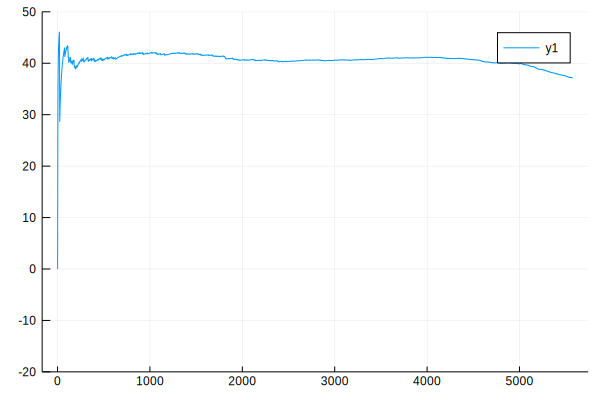

In [39]:
xx = []
yy = []
yyy = []
for (i, t) in enumerate(totals)
    push!(xx, i)
    push!(yy, t)
    push!(yyy, mean(yy))
end

plot(xx, yyy, ylims = (-20,50))

In [43]:
θ = convert(Matrix, CSV.read("0.472_theta_12.3_1_excellent"))


30420×6 Array{Float64,2}:
  -7.75822   0.0         -17.5157     0.0           -8.52952   0.0         
 -11.321     0.0         -17.9867     0.0          -14.8464    0.0         
  -7.93039   0.194639     -9.62185    0.0341359     -7.46501   0.0         
   3.12319   0.315427    -11.8554     0.0183138      4.64842   0.0         
   3.10259   0.0313613     3.99456    0.00300404     5.26929   0.0         
   1.72053   0.00934263    1.92919    0.0            0.789609  0.0         
   0.815414  0.0017382     1.80439    0.00685856     0.357617  7.99892e-321
  -0.056622  0.0247135    -0.0303718  0.000762062   -0.438564  0.000318762 
   0.937887  0.0255353     0.342298   0.0            0.706036  0.0040335   
  -0.34536   0.00871109    0.901897   0.0            0.844065  0.000776428 
  -1.02039   0.018768      1.78478    0.0            0.859658  0.0         
   0.33655   0.0385562     1.42007    0.0            0.727622  0.0430802   
   0.796222  0.00124996    0.776227   0.0            0.676645 

In [18]:
θ = convert(Matrix, thetaframe)

28080×6 Array{Float64,2}:
 -1.77704    0.0  -3.91139    0.0  -1.6716    0.0
  0.104306   0.0  -0.277353   0.0   0.29317   0.0
  0.0992801  0.0   2.52568    0.0   1.46481   0.0
  0.892081   0.0   2.81689    0.0   1.36093   0.0
  0.633067   0.0   0.479396   0.0   0.563874  0.0
  1.14868    0.0   0.109032   0.0   0.678002  0.0
  0.651611   0.0  -0.0357058  0.0   0.760664  0.0
  1.14689    0.0   1.85016    0.0   0.111559  0.0
  1.16463    0.0   0.581399   0.0   0.865836  0.0
  1.1367     0.0   1.04617    0.0   1.66769   0.0
  0.345221   0.0   0.929168   0.0   0.788199  0.0
  0.681581   0.0   1.02612    0.0   0.704559  0.0
  0.978036   0.0   0.321273   0.0   1.28954   0.0
  ⋮                                           ⋮  
  0.0        0.0   0.0        0.0   0.0       0.0
  0.0        0.0   0.0        0.0   0.0       0.0
  0.0        0.0   0.0        0.0   0.0       0.0
  0.0        0.0   0.0        0.0   0.0       0.0
  0.0        0.0   0.0        0.0   0.0       0.0
  0.0        0.0   0.0  

In [36]:
thetaframe = DataFrame(θ)
CSV.write("0.472_theta_12.3_1_excellent", thetaframe)

"0.472_theta_12.3_1_excellent"

In [51]:
b = ParticleCollection([[20, 60, 90, 1] for i in 1:N]);
ξ = weighted_grid_2(b)/N
var(ξ)


3.5612535612535624e-5